
## 1. Objective of Using an Ensemble in PD Modelling

The primary objective of introducing ensemble learners in Probability of Default (PD) modelling is to improve discriminatory power, stability, and robustness over individual base models.

In credit risk portfolios, no single modelling technique consistently captures:

Linear relationships (Logistic Regression),

Non-linear interactions (Random Forest),

Complex feature hierarchies (Gradient Boosting).

Ensembling allows the bank to combine complementary strengths of multiple PD models while mitigating their individual weaknesses.

## 2. Base Models Feeding the Ensemble (Upstream Inputs)

In the provided code, the ensemble learner is constructed after multiple independently trained PD models already exist.

Base PD Models

The following base learners are assumed to be pre-developed and calibrated:

Model	             Risk Modelling Interpretation
=====================================================            
PD_Survival	        Time-to-default / hazard-based PD
PD_logistic	        Benchmark regulatory model
PD_rfc	            Non-linear tree-based learner
PD_xgboost	        Gradient boosted decision trees
PD_xgboost_tuned	Hyperparameter-optimized GBM

Each model outputs a continuous PD estimate per obligor.

Important:
All models are evaluated on the same observation window and default definition, ensuring comparability.

## 3. Data Architecture for Ensemble Construction

The ensemble does not retrain base models. Instead, it operates at the prediction layer.

Each dataset (Train / Test / Validation) contains:

Column	Description
default_flag	Observed default (0/1)
PD_*	Model-specific PD predictions

This structure allows:

Parallel evaluation

Model-agnostic combination

Clean governance separation

## 4. Ensemble Strategy 1: Simple Average Model
Conceptual Definition

The Simple Average Ensemble assigns equal importance to each base model:

$\text PD_(avg)=\frac{1}{N} \Sigma_{i=1}^n\text PD_i $

Risk Rationale

Reduces model-specific noise

Stabilizes PDs across cycles

Often improves out-of-sample performance

## 5. Ensemble Strategy 2: Weighted Average Model
Conceptual Definition

Unlike simple averaging, this approach assigns performance-driven weights to each model:

$\text{PD}_{\text{weighted}} = \sum_{i=1}^{N} w_i \cdot \text{PD}_i$

Risk Governance Controls

Weight caps prevent dominance

Periodic re-estimation

Justified in Model Risk Practices
## 6. Ensemble Strategy 3: Meta-Learner (Stacked Model)
Conceptual Definition

A Meta-Learner is a second-level model trained to optimally combine base model predictions.

$\text PDmeta​=f(PD_1​,PD_2​,...,PD_N​)$
Where:

Inputs = Base model PDs

Output = Final PD

Training Approach (Industry Best Practice)

Out-of-fold predictions are generated from base models

These predictions form a new feature space

A simple, interpretable model (usually Logistic Regression) is trained because

Preserves monotonicity

Maintains explainability

Easier regulatory approval
## 7. Ensemble Evaluation Framework (Explicit in Code)

Once ensemble predictions exist, they are treated exactly like any other PD model.   

Key Evaluation Steps

Thresholding

Metric Computation

ROC-AUC

Gini

Confusion Matrix

Multi-Dataset Validation

Train → Overfitting check

Test → Generalization

Validation → Final selection

In [1]:
%store -r train_data_corr_eliminated
%store -r test_data_corr_eliminated
%store -r validation_data_corr_eliminated


%store -r train_data_with_pd
%store -r test_data_with_pd   	
%store -r validation_data_with_pd

%store -r train_data_logistic
%store -r test_data_logistic         
%store -r validation_data_logistic

%store -r train_data_rfc
%store -r test_data_rfc        
%store -r validation_data_rfc

%store -r train_data_xgboost
%store -r test_data_xgboost          
%store -r validation_data_xgboost

# Model Development Document (MDD)
PART A — ENSEMBLE CREATION CODE
Assumptions:

Base PD models are already trained, validated, and calibrated

All PDs:

Are on the same observation window

Use the same default definition

Are bounded in [0, 1]

DataFrames contain:

    -default_flag
    -PD_Survival
    -PD_logistic
    -PD_rfc
    -PD_xgboost
    -PD_xgboost_tuned


In [2]:
import pandas as pd
#Now adding all the predictions via developed models into the corr eliminated dataframes
train_data_corr_eliminated["PD_Survival"] = train_data_with_pd["PD_cph"]
train_data_corr_eliminated["PD_logistic"] = train_data_logistic["PD"]
train_data_corr_eliminated["PD_xgboost"] = train_data_xgboost["PD_xgboost"]
train_data_corr_eliminated["PD_xgboost_tuned"] = train_data_xgboost["PD_xgboost_tuned"]
train_data_corr_eliminated["PD_rfc"]=train_data_rfc["PD"]

test_data_corr_eliminated["PD_Survival"] = test_data_with_pd["PD_cph"]
test_data_corr_eliminated["PD_logistic"] = test_data_logistic["PD"]
test_data_corr_eliminated["PD_xgboost"] = test_data_xgboost["PD_xgboost"]
test_data_corr_eliminated["PD_xgboost_tuned"] = test_data_xgboost["PD_xgboost_tuned"]
test_data_corr_eliminated["PD_rfc"]=test_data_rfc["PD"]



validation_data_corr_eliminated["PD_Survival"] = validation_data_with_pd["PD_cph"]
validation_data_corr_eliminated["PD_logistic"] = validation_data_logistic["PD"]
validation_data_corr_eliminated["PD_xgboost"] = validation_data_xgboost["PD_xgboost"]
validation_data_corr_eliminated["PD_xgboost_tuned"] = validation_data_xgboost["PD_xgboost_tuned"]
validation_data_corr_eliminated["PD_rfc"]=validation_data_rfc["PD"]

In [3]:
# 1. SIMPLE AVERAGE ENSEMBLE
# Equal-weight aggregation of base PDs.

def create_simple_average_ensemble(df, base_models):
    df = df.copy()
    df["Average"] = df[base_models].mean(axis=1)
    return df

In [4]:
base_models = [
    "PD_Survival",
    "PD_logistic",
    "PD_rfc",
    "PD_xgboost",
    "PD_xgboost_tuned"
]

train_data = create_simple_average_ensemble(train_data_corr_eliminated, base_models)
test_data = create_simple_average_ensemble(test_data_corr_eliminated, base_models)
validation_data = create_simple_average_ensemble(validation_data_corr_eliminated, base_models)


The Simple Average Ensemble PD model is constructed by assigning equal weights to all approved base PD models. This approach reduces idiosyncratic model noise and improves stability across economic cycles while maintaining full transparency and interpretability. No model dominance is permitted under this methodology.

2. WEIGHTED AVERAGE ENSEMBLE
   
Concept

Performance-driven aggregation using pre-approved fixed weights.

Important:
Weights are not optimized in-sample which avoids overfitting.

The following function is defined  to create Weighted Average Ensemble PD using fixed, governed weights whcih ensured that

    - The Sum of weights= 1.00
    - The weights are Logistic anchored for regulatory stability
    -The weights help the ML models capped to prevent dominance

In [5]:
def create_weighted_average_ensemble(df, model_weights):
      
    df = df.copy()

    weighted_pd = 0
    for model, weight in model_weights.items():
        weighted_pd += weight * df[model]

    df["Weighted Average"] = weighted_pd
    return df


In [6]:
# We pass coverned weights to this function in a dictionary model_weights
model_weights = {
    "PD_logistic": 0.25,
    "PD_Survival": 0.20,
    "PD_xgboost": 0.20,
    "PD_xgboost_tuned": 0.20,
    "PD_rfc": 0.15
}

In [7]:
train_data = create_weighted_average_ensemble(train_data_corr_eliminated, model_weights)
test_data = create_weighted_average_ensemble(test_data_corr_eliminated, model_weights)
validation_data = create_weighted_average_ensemble(validation_data_corr_eliminated, model_weights)

The Weighted Average Ensemble PD model aggregates individual PD estimates using fixed weights determined based on out-of-sample discriminatory power, calibration performance, and expert judgement. Weight constraints are applied to ensure no single model disproportionately influences the final PD estimate. The weighting scheme is reviewed periodically under the model governance framework.

3. META-LEARNER (STACKED ENSEMBLE):-

    -Regulatory Design Principles

    -Uses only PD outputs as inputs

    -Second-stage model is Logistic Regression

    -Trained on out-of-fold predictions

    -Fully explainable coefficients

# 3.1 Meta-Learner Training (K-Fold)
Train a Logistic Regression meta-learner using K-fold(Out-of-fold) predictions.

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
import numpy as np

def train_meta_learner(train_df, base_models, target, n_splits=5):
    X = train_df[base_models].values
    y = train_df[target].values

    oof_preds = np.zeros(len(train_df))
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train = y[train_idx]

        meta_model = LogisticRegression(
            solver="lbfgs",
            max_iter=1000
        )
        meta_model.fit(X_train, y_train)
        oof_preds[val_idx] = meta_model.predict_proba(X_val)[:, 1]

    # Final model trained on full data
    final_meta_model = LogisticRegression(
        solver="lbfgs",
        max_iter=1000
    )
    final_meta_model.fit(X, y)

    return final_meta_model, oof_preds


# 3.2 Meta Learner Prediction Function

In [9]:
def apply_meta_learner(df, meta_model, base_models):
     df = df.copy()
     X = df[base_models].values
     df["Meta Learner"] = meta_model.predict_proba(X)[:, 1]
     return df

# 3.3 Full Meta Learner Workflow

In [10]:
# Since the training ,test and validation columns from the XGBoost model contains Null calues in the PD_xgboost and PD_xg_boost_tuned 
# we may consider imputing the missing values using the median method.
for col in ['PD_xgboost', 'PD_xgboost_tuned']:
    train_data_corr_eliminated[f'{col}_is_missing'] = train_data_corr_eliminated[col].isnull().astype(int)
    test_data_corr_eliminated[f'{col}_is_missing'] = test_data_corr_eliminated[col].isnull().astype(int)
    validation_data_corr_eliminated[f'{col}_is_missing'] = validation_data_corr_eliminated[col].isnull().astype(int)
    
train_data_corr_eliminated["PD_xgboost"] = train_data_corr_eliminated["PD_xgboost"].fillna(train_data_corr_eliminated["PD_xgboost"].median())
test_data_corr_eliminated["PD_xgboost"] = test_data_corr_eliminated["PD_xgboost"].fillna(test_data_corr_eliminated["PD_xgboost"].median())
validation_data_corr_eliminated["PD_xgboost"] = validation_data_corr_eliminated["PD_xgboost"].fillna(validation_data_corr_eliminated["PD_xgboost"].median())

train_data_corr_eliminated["PD_xgboost_tuned"] = train_data_corr_eliminated["PD_xgboost_tuned"].fillna(train_data_corr_eliminated["PD_xgboost_tuned"].median())
test_data_corr_eliminated["PD_xgboost_tuned"] = test_data_corr_eliminated["PD_xgboost_tuned"].fillna(test_data_corr_eliminated["PD_xgboost_tuned"].median())
validation_data_corr_eliminated["PD_xgboost_tuned"] = validation_data_corr_eliminated["PD_xgboost_tuned"].fillna(validation_data_corr_eliminated["PD_xgboost_tuned"].median())


In [11]:
final_meta_model, train_oof_meta_pd = train_meta_learner(
    train_data_corr_eliminated,
    base_models,
    target="default_flag"
)

In [12]:
train_data["Meta Learner"] = train_oof_meta_pd
test_data = apply_meta_learner(test_data_corr_eliminated,final_meta_model,base_models)
validation_data = apply_meta_learner(validation_data_corr_eliminated,final_meta_model,base_models)

The Meta-Learner PD model employs a two-stage stacking methodology. In the first stage, multiple independently validated PD models generate probability estimates. In the second stage, a logistic regression model is trained on K-out-of-fold base model predictions to produce the final PD. This approach enhances discriminatory power while preserving interpretability and compliance with model risk management standards.

Three ensemble PD methodologies were developed: Simple Average, Weighted Average, and Meta-Learner. Each ensemble aggregates validated base model PDs while adhering to transparency, stability, and governance requirements. The Meta-Learner uses a logistic regression stacking framework trained on K-out-of-fold predictions to enhance discriminatory power without compromising interpretability. All ensemble models are evaluated consistently across training, test, and validation datasets.

In [13]:
train_data.head()

,Unnamed: 0,id,date,saving_ratio,default_flag,max_dpd_6_months,problematic_cheque_count,duration_in_month,credit_amount,installment_as_income_perc,...,other_debtors_mean_encoded,purpose_mean_encoded,sector_risk_capped_0.99_woe_encoded,PD_Survival,PD_logistic,PD_xgboost,PD_xgboost_tuned,PD_rfc,Weighted Average,Meta Learner
455,455,456,2020-12-20,0.46,0,0,3,24,2679,4,...,0.29989,0.165049,-0.001891,0.059534,0,0.003230,0.031173,0,0.018787,0.007076
516,516,517,2022-09-27,0.04,0,0,0,6,1361,2,...,0.29989,0.380342,-0.001891,0.010030,0,0.001710,0.031173,0,0.008582,0.006648
147,147,148,2021-04-16,0.50,0,0,0,12,682,4,...,0.29989,0.380342,-0.001891,0.711581,1,0.205564,0.494341,0,0.532297,0.157403
789,789,790,2022-05-13,0.67,1,0,2,40,5998,4,...,0.29989,0.440000,-0.001891,0.966704,1,0.982289,0.901118,1,0.970022,0.989723
121,121,122,2020-03-19,0.22,0,0,1,24,3868,4,...,0.29989,0.165049,-0.001891,0.047330,0,0.007988,0.031173,0,0.017298,0.006939


In [14]:
test_data_corr_eliminated.head()

,Unnamed: 0,id,date,saving_ratio,default_flag,max_dpd_6_months,problematic_cheque_count,duration_in_month,credit_amount,installment_as_income_perc,...,other_debtors_mean_encoded,purpose_mean_encoded,sector_risk_capped_0.99_woe_encoded,PD_Survival,PD_logistic,PD_xgboost,PD_xgboost_tuned,PD_rfc,PD_xgboost_is_missing,PD_xgboost_tuned_is_missing
828,828,829,2020-06-27,0.15,1,0,0,36,8335,3,...,0.29989,0.165049,-0.001891,0.988274,1,0.005106,0.052687,1,1,1
321,321,322,2022-02-10,0.64,1,0,1,24,1938,4,...,0.29989,0.221429,-0.001891,0.986574,1,0.005106,0.052687,1,1,1
493,493,494,2020-08-06,0.49,0,0,3,6,368,4,...,0.29989,0.221429,-0.001891,0.209869,0,0.005106,0.052687,0,1,1
835,835,836,2023-02-16,0.67,1,0,2,12,1082,4,...,0.29989,0.380342,-0.001891,0.868957,1,0.005106,0.052687,1,1,1
923,923,924,2022-01-30,0.46,0,0,2,12,2002,3,...,0.29989,0.380342,-0.001891,0.024947,0,0.005106,0.052687,0,1,1


In [15]:
validation_data

,Unnamed: 0,id,date,saving_ratio,default_flag,max_dpd_6_months,problematic_cheque_count,duration_in_month,credit_amount,installment_as_income_perc,...,purpose_mean_encoded,sector_risk_capped_0.99_woe_encoded,PD_Survival,PD_logistic,PD_xgboost,PD_xgboost_tuned,PD_rfc,PD_xgboost_is_missing,PD_xgboost_tuned_is_missing,Meta Learner
22,22,23,2023-11-14,0.12,0,0,1,10,2241,1,...,0.380342,-0.001891,0.000000,0,0.001445,0.031173,0,0,0,0.005369
26,26,27,2023-12-21,0.12,0,0,3,6,426,4,...,0.221429,-0.001891,0.023780,0,0.002464,0.031173,0,0,0,0.005611
32,32,33,2023-11-09,0.07,0,0,1,18,5866,2,...,0.380342,-0.001891,0.164261,0,0.005827,0.052113,0,0,0,0.007335
46,46,47,2023-06-05,0.46,0,0,3,36,2299,4,...,0.221429,-0.001891,0.130294,0,0.000872,0.031173,0,0,0,0.006786
58,58,59,2023-11-28,0.49,0,0,0,18,1961,3,...,0.380342,-0.001891,0.001225,0,0.000657,0.031173,0,0,0,0.005376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
989,989,990,2023-11-25,0.43,0,0,1,24,1743,4,...,0.221429,-0.001891,0.294823,0,0.003196,0.080158,0,0,0,0.009383
991,991,992,2023-09-22,0.10,0,0,0,15,1569,4,...,0.221429,-0.001891,0.213002,0,0.003607,0.031173,0,0,0,0.007901
995,995,996,2023-08-14,0.29,0,0,3,12,1736,3,...,0.320442,-0.001891,0.024607,0,0.000929,0.031173,0,0,0,0.005610
997,997,998,2023-07-28,0.39,0,0,3,12,804,4,...,0.221429,-0.001891,0.472665,0,0.007372,0.057492,0,0,0,0.012820


# Classification Report For Ensemble

    -Supports class imbalance analysis
    -Allows bad-rate capture review
    -Ready for regulatory reporting

In [16]:

from sklearn.metrics import classification_report
def generate_classification_report(
    df,
    pd_column,
    target_column="default_flag",
    threshold=0.5,
    dataset_name="Dataset"
):
    """
    Generate classification report for a PD model at a fixed threshold.
    """
    y_true = df[target_column]
    y_pred = (df[pd_column] >= threshold).astype(int)

    report = classification_report(
        y_true,
        y_pred,
        output_dict=True
    )

    report_df = pd.DataFrame(report).T
    report_df["Dataset"] = dataset_name
    report_df["Model"] = pd_column

    return report_df



In [17]:
def ensemble_classification_reports(
    train_df,
    test_df,
    validation_df,
    ensemble_models,
    threshold=0.5
):
    """
    Generate classification reports for ensemble models across datasets.
    """
    reports = []

    for model in ensemble_models:
        reports.append(
            generate_classification_report(
                train_df,
                model,
                dataset_name="Train",
                threshold=threshold
            )
        )

        reports.append(
            generate_classification_report(
                test_df,
                model,
                dataset_name="Test",
                threshold=threshold
            )
        )

        reports.append(
            generate_classification_report(
                validation_df,
                model,
                dataset_name="Validation",
                threshold=threshold
            )
        )

    final_report = pd.concat(reports).reset_index()
    final_report.rename(columns={"index": "Metric"}, inplace=True)

    return final_report


In [18]:
ensemble_models = ["PD_logistic","PD_rfc","PD_Survival","PD_xgboost","PD_xgboost_tuned","Meta Learner"]


In [19]:
ensemble_classification_report = ensemble_classification_reports(
    train_data,
    test_data,
    validation_data,
    ensemble_models,
    threshold=0.5
)


In [20]:
pd.options.display.max_rows=None

In [21]:
ensemble_classification_report

,Metric,precision,recall,f1-score,support,Dataset,Model
0,0,0.968447,0.963768,0.966102,414.000000,Train,PD_logistic
1,1,0.917582,0.927778,0.922652,180.000000,Train,PD_logistic
2,accuracy,0.952862,0.952862,0.952862,0.952862,Train,PD_logistic
3,macro avg,0.943015,0.945773,0.944377,594.000000,Train,PD_logistic
4,weighted avg,0.953033,0.952862,0.952935,594.000000,Train,PD_logistic
5,0,0.982456,0.960000,0.971098,175.000000,Test,PD_logistic
6,1,0.916667,0.962500,0.939024,80.000000,Test,PD_logistic
7,accuracy,0.960784,0.960784,0.960784,0.960784,Test,PD_logistic
8,macro avg,0.949561,0.961250,0.955061,255.000000,Test,PD_logistic
9,weighted avg,0.961816,0.960784,0.961036,255.000000,Test,PD_logistic


Classification performance for ensemble PD models was assessed using a fixed probability threshold of 0.5. This threshold was selected for benchmarking purposes and does not represent the operational decision cut-off used for credit approval or staging.

Precision, recall, and F1-score were evaluated separately for default and non-default classes to assess the trade-off between default capture and false positive rates. Macro and weighted averages were reviewed to account for class imbalance.

Classification performance was assessed across training, test, and validation datasets to identify potential overfitting and to ensure generalization of ensemble model performance.

Classification reports supplement rank-ordering and calibration metrics and are not used in isolation for model selection. Final model selection is based on a composite assessment of discriminatory power, calibration, stability, and business impact.

# Observing Discriminatory Power

In [22]:
import numpy as np
import pandas as pd
def calculate_ks(y_true, y_pred_prob, n_bins=10):
    """
    Calculate KS statistic for a PD model.
    """
    df = pd.DataFrame({
        "y_true": y_true,
        "pd": y_pred_prob
    })

    df["bucket"] = pd.qcut(df["pd"], q=n_bins, duplicates="drop")

    grouped = df.groupby("bucket").agg(
        total_obs=("y_true", "count"),
        bads=("y_true", "sum")
    )

    grouped["goods"] = grouped["total_obs"] - grouped["bads"]

    grouped["cum_bad_rate"] = grouped["bads"].cumsum() / grouped["bads"].sum()
    grouped["cum_good_rate"] = grouped["goods"].cumsum() / grouped["goods"].sum()

    grouped["ks"] = np.abs(
        grouped["cum_bad_rate"] - grouped["cum_good_rate"]
    )

    ks_value = grouped["ks"].max()

    return ks_value, grouped.reset_index()



In [23]:
def ensemble_ks_scores(
    train_df,
    test_df,
    validation_df,
    ensemble_models,
    target_column="default_flag"
):
    records = []

    for model in ensemble_models:
        for dataset_name, df in [
            ("Train", train_df),
            ("Test", test_df),
            ("Validation", validation_df)
        ]:
            ks_value, _ = calculate_ks(
                df[target_column],
                df[model]
            )

            records.append({
                "Model": model,
                "Dataset": dataset_name,
                "KS": ks_value
            })

    return pd.DataFrame(records)


| KS Value    | Interpretation |
| ----------- | -------------- |
| < 0.20      | Weak           |
| 0.20 – 0.40 | Moderate       |
| 0.40 – 0.60 | Strong         |
| > 0.60      | Very strong    |


In [24]:
ensemble_ks_scores(
    train_data,
    test_data,
    validation_data,
    ensemble_models,
    target_column="default_flag")

C:\Users\siddh\AppData\Local\Temp\ipykernel_11372\2365775721.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby("bucket").agg(
C:\Users\siddh\AppData\Local\Temp\ipykernel_11372\2365775721.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby("bucket").agg(
C:\Users\siddh\AppData\Local\Temp\ipykernel_11372\2365775721.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = 

,Model,Dataset,KS
0,PD_logistic,Train,0.000000
1,PD_logistic,Test,0.000000
2,PD_logistic,Validation,0.000000
3,PD_rfc,Train,0.000000
4,PD_rfc,Test,0.000000
5,PD_rfc,Validation,0.000000
6,PD_Survival,Train,0.861353
7,PD_Survival,Test,0.889643
8,PD_Survival,Validation,0.920946
9,PD_xgboost,Train,0.993220


In [25]:
# ROC Curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve,roc_auc_score
def plot_ensemble_roc_curves(df, ensemble_models, target_column, dataset_name):
    plt.figure(figsize=(10, 6))
    for model in ensemble_models:
        # 2026 Best Practice: Clean NaNs per-model to ensure finite input
        valid_data = df[[target_column, model]].dropna()
        y_true = valid_data[target_column]
        y_pred_prob = valid_data[model]
        
        if len(y_true) == 0:
            print(f"Warning: No valid data for model {model}")
            continue

        fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
        auc = roc_auc_score(y_true, y_pred_prob)
        plt.plot(fpr, tpr, label=f"{model} (AUC={auc:.3f})"
        )

    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curves – {dataset_name}")
    plt.legend()
    plt.grid(True)
    plt.show()

In [26]:
def ensemble_auc_scores(train_df, test_df, validation_df, ensemble_models, target_column="default_flag"):
    records = []
    
    for model in ensemble_models:
        for dataset_name, df in [
            ("Train", train_df),
            ("Test", test_df),
            ("Validation", validation_df)
        ]:
            #  Drop NaNs only for the columns needed for this specific calculation
            # This prevents roc_auc_score from crashing
            valid_df = df[[target_column, model]].dropna()
            
            if valid_df.empty:
                print(f"Warning: {dataset_name} for {model} is empty after dropping NaNs.")
                continue
                
            auc = roc_auc_score(
                valid_df[target_column],
                valid_df[model]
            )

            records.append({
                "Model": model,
                "Dataset": dataset_name,
                "ROC_AUC": auc
            })

    return pd.DataFrame(records)


In [27]:
ensemble_auc_scores(train_data,test_data,validation_data,ensemble_models,target_column="default_flag")

,Model,Dataset,ROC_AUC
0,PD_logistic,Train,0.945773
1,PD_logistic,Test,0.961250
2,PD_logistic,Validation,0.948986
3,PD_rfc,Train,1.000000
4,PD_rfc,Test,1.000000
5,PD_rfc,Validation,1.000000
6,PD_Survival,Train,0.989412
7,PD_Survival,Test,0.992714
8,PD_Survival,Validation,0.990991
9,PD_xgboost,Train,0.999973


C:\Users\siddh\AppData\Local\Temp\ipykernel_11372\2365775721.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby("bucket").agg(
C:\Users\siddh\AppData\Local\Temp\ipykernel_11372\2365775721.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby("bucket").agg(
C:\Users\siddh\AppData\Local\Temp\ipykernel_11372\2365775721.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = 

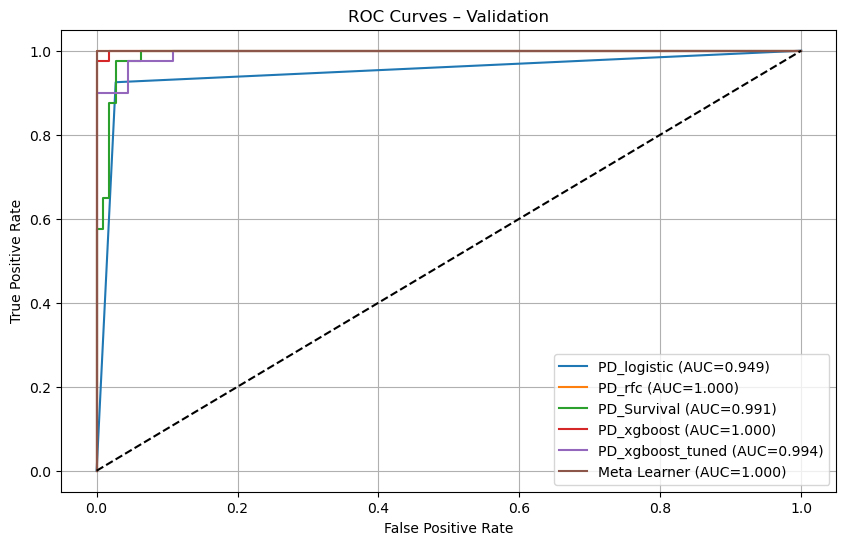

               Model     Dataset        KS
0        PD_logistic       Train  0.000000
1        PD_logistic        Test  0.000000
2        PD_logistic  Validation  0.000000
3             PD_rfc       Train  0.000000
4             PD_rfc        Test  0.000000
5             PD_rfc  Validation  0.000000
6        PD_Survival       Train  0.861353
7        PD_Survival        Test  0.889643
8        PD_Survival  Validation  0.920946
9         PD_xgboost       Train  0.993220
10        PD_xgboost        Test  0.306786
11        PD_xgboost  Validation  0.954955
12  PD_xgboost_tuned       Train  0.943548
13  PD_xgboost_tuned        Test  0.325000
14  PD_xgboost_tuned  Validation  0.920946
15      Meta Learner       Train  0.988889
16      Meta Learner        Test  0.962500
17      Meta Learner  Validation  0.954955
               Model     Dataset   ROC_AUC
0        PD_logistic       Train  0.945773
1        PD_logistic        Test  0.961250
2        PD_logistic  Validation  0.948986
3          

In [28]:
ensemble_models = ["PD_logistic","PD_rfc","PD_Survival","PD_xgboost","PD_xgboost_tuned","Meta Learner"]


# KS
ks_results = ensemble_ks_scores(
    train_data,
    test_data,
    validation_data,
    ensemble_models
)

# ROC-AUC
auc_results = ensemble_auc_scores(
    train_data,
    test_data,
    validation_data,
    ensemble_models
)


# ROC Curves (Validation)
plot_ensemble_roc_curves(
    validation_data,
    ensemble_models,
    dataset_name="Validation",
    target_column="default_flag"
)
print(ks_results)
print(auc_results)


KS Statistic

The Kolmogorov–Smirnov (KS) statistic was used to assess the discriminatory power of ensemble PD models. KS values were evaluated across training, test, and validation datasets to ensure stability and absence of overfitting.

Receiver Operating Characteristic (ROC) curves and corresponding Area Under the Curve (AUC) metrics were reviewed to assess rank-ordering performance of ensemble models. ROC analysis was conducted consistently across all datasets.

# PSI Ensemble model
The Population Stability Index (PSI) remains the industry standard in credit risk for monitoring "model drift." In the context of  calibration ensemble, PSI measures whether the distribution of predicted probabilities (PDs) has shifted significantly between the training (Expected) population and the live/validation (Actual) population.

PSI is calculated by comparing the percentage of observations in defined "bins" (usually deciles):
$(PSI=\sum \left((\%Actual-\%Expected)\times \ln \left(\frac{\%Actual}{\%Expected}\right)\right))$
# Interpretation Thresholds
These industry benchmarks determine if a calibrated model needs retraining

    -PSI < 0.10: Low Shift. The calibration is stable; no action required.
    -0.10 ≤ PSI < 0.25: Moderate Shift. The model is drifting. Investigate if the ensemble weights or calibration (Platt/Isotonic) need updating. 
    -PSI ≥ 0.25: Significant Shift. The population has changed fundamentally (e.g., economic shock). The model or its calibrator is likely invalid.

In [29]:
def calculate_psi(expected, actual, n_bins=10, eps=1e-6):
    # 1. Clean data: drop NaNs and ensure numeric Series
    expected = pd.Series(expected).dropna()
    actual = pd.Series(actual).dropna()

    # 2. Define Breakpoints based on Expected distribution
    # np.unique is critical here for Regression ties
    breakpoints = np.unique(np.percentile(expected, np.linspace(0, 100, n_bins + 1)))

    # 3. Bin the data
    # duplicates="drop" handles the remaining edge cases where intervals collapse
    expected_bins = pd.cut(expected, breakpoints, include_lowest=True, duplicates="drop")
    actual_bins = pd.cut(actual, breakpoints, include_lowest=True, duplicates="drop")

    # 4. Calculate distributions
    # Wrap in pd.Series() to ensure .value_counts(normalize=True) works
    expected_dist = pd.Series(expected_bins).value_counts(normalize=True).sort_index()
    actual_dist = pd.Series(actual_bins).value_counts(normalize=True).sort_index()

    # 5. Align indices: ensure 'actual' has same bins as 'expected' even if 0 count
    expected_dist, actual_dist = expected_dist.align(actual_dist, fill_value=0)

    # 6. Apply PSI Formula with smoothing (eps)
    psi = np.sum((actual_dist - expected_dist) * np.log((actual_dist + eps) / (expected_dist + eps)))
    
    return psi


In [30]:
calculate_psi(
    validation_data["Meta Learner"],
    train_data["Meta Learner"],
    n_bins=10,
    eps=1e-6
)

np.float64(4.14351051058871)

In [31]:
def ensemble_psi_scores(
    train_df,
    test_df,
    validation_df,
    ensemble_models
):
    records = []

    for model in ensemble_models:
        psi_test = calculate_psi(
            train_df[model],
            test_df[model]
        )

        psi_validation = calculate_psi(
            train_df[model],
            validation_df[model]
        )

        records.append({
            "Model": model,
            "PSI_Train_vs_Test": psi_test,
            "PSI_Train_vs_Validation": psi_validation
        })

    return pd.DataFrame(records)


In [32]:
ensemble_psi_scores(
    train_data,
    test_data,
    validation_data,
    ensemble_models)

,Model,PSI_Train_vs_Test,PSI_Train_vs_Validation
0,PD_logistic,0.000000,0.000000
1,PD_rfc,0.000000,0.000000
2,PD_Survival,0.047820,0.106211
3,PD_xgboost,1.938590,0.072973
4,PD_xgboost_tuned,1.988513,0.023070
5,Meta Learner,0.429287,0.207197


In credit risk modeling, the following standard thresholds are used to determine when a model remains "stable" or requires action:

    -PSI < 0.10 (Excellent/Stable): No significant change in the population. The model is considered rock solid, and you can continue using it without adjustments.
    -0.10 ≤ PSI < 0.25 (Warning/Moderate Shift): A "grey area" indicating the population has started to drift. You should monitor the model closely and investigate which variables are driving the change.
    -PSI ≥ 0.25 (Action Required/Significant Shift): There has been a substantial change in borrower characteristics or behavior. In 2026, this is a clear trigger to recalibrate or retrain the model to ensure it remains accurate for the current population. 

Maintaining a low PSI is increasingly critical due to:
Regulatory Imperatives: New frameworks (e.g., RBI's updated credit risk directions effective April 2026) emphasize tighter governance and real-time monitoring.
Dynamic Markets: With shifts in unsecured retail and SME lending expected to impact asset quality by March 2026, model leaders are moving beyond vintage scorecards toward real-time early-warning triggers.
Calibration Efficiency: Under Basel IV reforms, accurate calibration is essential for capital efficiency. Models with high drift (high PSI) may lose competitive advantage if they trigger higher capital floor requirements. 